# **PCA**

**need the python kernal**

In [ ]:
read.csv("../../data/blood/dataframes/model4/")

In [35]:
#removing the H3k27me3 predictors to accomodate liver
#this also ensures that the cols are in the same order 
cut -f 1-22,26-50  ../../data/skin/dataframes/model2/predictorDf.txt > ../../data/global/pca/skin_data_H3k27me3_removed.txt
cut -f 1-22,26-50  ../../data/germline/dataframes/model2/predictorDf.txt > ../../data/global/pca/germline_data_H3k27me3_removed.txt
cut -f 1-19,23-50  ../../data/blood/dataframes/model2/predictorDf.txt > ../../data/global/pca/blood_data_H3k27me3_removed.txt

In [42]:
%%bash
#combining all data and including a column for tissue 
awk '{print "tissue\t"$0}' ../../data/global/pca/blood_data_H3k27me3_removed.txt | head -n 1 > ../../data/global/pca/all_data.tsv
awk '{print "blood\t"$0}' ../../data/global/pca/blood_data_H3k27me3_removed.txt | tail -n +2 >> ../../data/global/pca/all_data.tsv
awk '{print "skin\t"$0}' ../../data/global/pca/skin_data_H3k27me3_removed.txt | tail -n +2 >> ../../data/global/pca/all_data.tsv
awk '{print "liver\t"$0}' ../../data/liver/dataframes/model2/predictorDf.txt | tail -n +2 >> ../../data/global/pca/all_data.tsv  #missing H3k27me3 predcitor --> cant be comb
awk '{print "germline\t"$0}' ../../data/global/pca/germline_data_H3k27me3_removed.txt | tail -n +2 >> ../../data/global/pca/all_data.tsv 

In [43]:
!wc -l ../../data/global/pca/all_data.tsv

1181174 ../../data/global/pca/all_data.tsv


**need an r kernel**

In [17]:
library(dplyr)
library(stringi)
library(stats)
library(ggplot2)

In [18]:
all_data <- read.table("../../data/global/pca/all_data.tsv",header=TRUE)

In [19]:
all_data <- all_data %>%
    mutate(GC_content.1 = Gpercent.1+Cpercent.1) %>%
    mutate(GC_content.100 = Gpercent.100+Cpercent.100) %>% 
    mutate(GC_content.10000 = Gpercent.10000+Cpercent.10000)
all_data <- all_data[,!(names(all_data) %in% c("site",'Apercent.1','Gpercent.1','Cpercent.1','Tpercent.1',
                                       'Apercent.100','Gpercent.100','Cpercent.100','Tpercent.100',
                                       'Apercent.10000','Gpercent.10000','Cpercent.10000','Tpercent.10000'))]

In [20]:
#converting 64-->32 triplets 
rc_removeAG <- function(dna){
    middle_base = substr(dna, 2, 2)
    if(middle_base %in% c("A","G")){
        dna <- stri_reverse(chartr("acgtACGT", "tgcaTGCA", dna))}
    return(dna)
}#substring slicing https://www.johnmyleswhite.com/notebook/2009/02/25/text-processing-in-r/
all_data$triplet <- unlist(lapply(as.character(all_data$triplet),rc_removeAG)) 

#editing the triplets 
all_data$triplet <- toupper(all_data$triplet)
#filter for rows that dont have NNN as the triplet --> write the details to file 
# cat(paste(nrow(all_data[all_data$triplet == "NNN",]), "rows removed due to N in triplet, ",sep=" "),file=error_output_file,sep="\n",append=TRUE)
all_data <- all_data[all_data$triplet != "NNN",]
# cat(paste(nrow(all_data),"rows left",sep=" "),file=error_output_file,sep="\n",append=TRUE)

#check for problems with levels / column tye etc. 
all_data$triplet <- as.character(all_data$triplet) #need to convert to char so the as.factor properly reducs to 64 levels after the removal of 'triplets" longer than 3
string_to_print = paste(nrow(all_data[nchar(as.character(all_data$triplet))!=3,]),"rows removed due to triplet larger than 3 in length ",sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
print(string_to_print)
all_data <- all_data[nchar(all_data$triplet)==3,] #make sure only including triplets 
string_to_print=paste(nrow(all_data)," rows left", sept = " ")
print(string_to_print)
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

#factorizing the columns 
all_data$mutation_status <- as.factor(all_data$mutation_status)
all_data$triplet <- as.factor(all_data$triplet)
all_data$Chromosome <- as.factor(all_data$Chromosome)

#checking that the factor variables are correct (mutation status, triplets, chroms) --> will raise error if not true 
stopifnot(length(levels(all_data$mutation_status)) == 2)
stopifnot(length(levels(all_data$triplet))==32)
stopifnot(length(levels(all_data$Chromosome))==22)

[1] "0 rows removed due to triplet larger than 3 in length "
[1] "1142674  rows left  "


In [21]:
#na omit and checking how many rows were removed 
string_to_print = paste(nrow(all_data)- nrow(na.omit(all_data)), "lost to NA values, ", nrow(na.omit(all_data))," rows remain after",sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
print(string_to_print)
all_data <- na.omit(all_data)



[1] "13307 lost to NA values,  1129367  rows remain after"


# **setting up model description**

In [33]:
model_desc = "allData_allMuts"
amount_to_red_by = 100

In [23]:
#setting up the df for all equivalent
equiv_data <- all_data %>% filter(tissue == "blood") 

#cutting down the larger sections to the same # rows as blood (16613)
equiv_germline = (filter(all_data,tissue == "germline")[sample(nrow(filter(all_data,tissue == "germline")), 16613), ])
equiv_skin = (filter(all_data,tissue == "skin")[sample(nrow(filter(all_data,tissue == "skin")), 16613), ])
equiv_liver = (filter(all_data,tissue == "liver")[sample(nrow(filter(all_data,tissue == "liver")), 16613), ])

#combine the equivalent dfs 
equiv_data <- rbind(equiv_data,equiv_germline)
equiv_data <- rbind(equiv_data,equiv_skin)
equiv_data <- rbind(equiv_data,equiv_liver)


In [24]:
data_to_use = all_data %>% filter(mutation_status == "1")
data_to_use<- data_to_use[,!(names(data_to_use) %in% c("mutation_status"))]

In [25]:
#create the predictor and reponse for the model input. any NA OMit? can we use the same indexies? 
predictor_matrix = model.matrix(Chromosome~., data_to_use)[,-1]  #got this from the book, idk . removes NA coloumn and (takes out) the reponse coloum cool cool cool 
stopifnot(nrow(data_to_use)==nrow(predictor_matrix))

In [26]:
pca <- prcomp(predictor_matrix, scale=TRUE)

In [27]:
pca_var <- pca$sdev^2
pca_var_percent <- round(pca_var/sum(pca_var)*100,1)

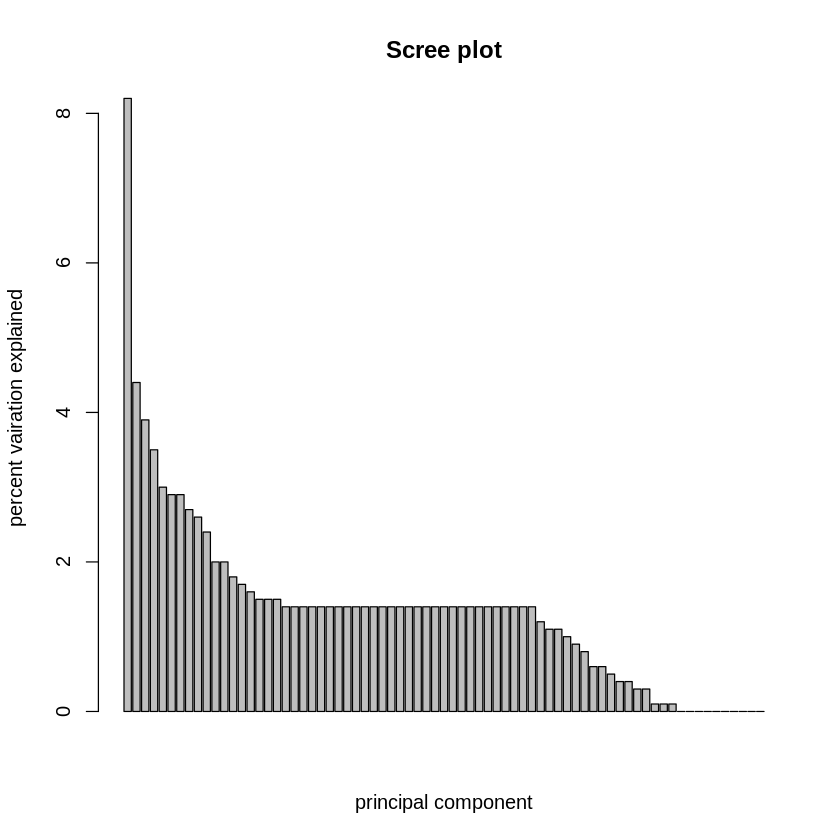

In [28]:
barplot(pca_var_percent, main="Scree plot",ylab="percent vairation explained",xlab="principal component")

In [180]:
#saving the above 
jpeg(paste("plots/pca/scree_plot_",model_desc,".jpeg",sep=""))
barplot(pca_var_percent, main="Scree plot",ylab="percent variation explained",xlab="principal component")
dev.off() 

png 
  2

In [29]:
pca_data <- data.frame(Tissue=data_to_use$tissue, X=pca$x[,1], Y=pca$x[,2])

In [30]:
pca_data_reduced =  pca_data[sample(nrow(pca_data), nrow(pca_data)/amount_to_red_by), ]

Saving 6.67 x 6.67 in image



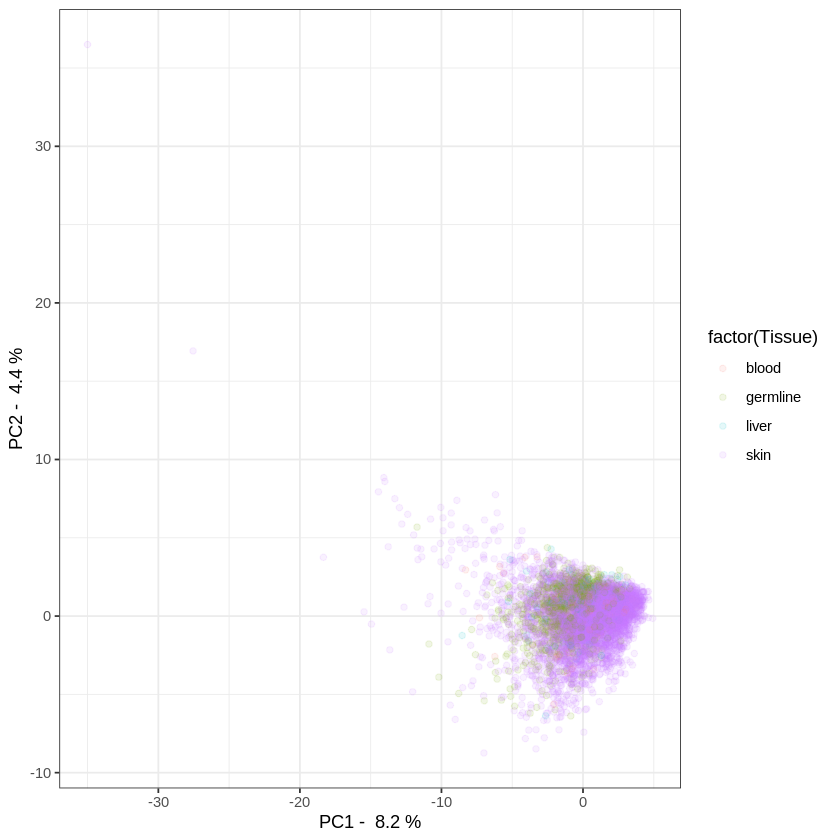

In [34]:
ggplot(data=pca_data_reduced, aes(x=X, y=Y))+ 
    geom_point(aes(colour = factor(Tissue)),alpha=0.1)+
    xlab(paste("PC1 - ",pca_var_percent[1],"%",sep=" "))+
    ylab(paste("PC2 - ",pca_var_percent[2],"%",sep=" "))+
    theme_bw()
ggsave(paste("plots/pca/pca_",model_desc,".pdf",sep=""))

In [76]:
pred_score_ranked <- sort(abs(pca$rotation[,1]), decreasing=TRUE)
top_10_preds = names(pred_score_ranked[1:20])

In [77]:
print(pca$rotation[top_10_preds,1])

      H3k27.10000     H3k4me1.10000         H3k27.100       DNAse.10000 
        0.2682163         0.2669629         0.2647105         0.2643247 
          H3k27.1       H3k4me1.100  GC_content.10000         H3k4me1.1 
        0.2613668         0.2305598         0.2230347         0.2194528 
    H3k4me3.10000 Replication.10000   Replication.100     Replication.1 
        0.2125036        -0.2034432        -0.2031129        -0.2030964 
    laminB1.10000       H3k4me3.100         H3k4me3.1    GC_content.100 
       -0.2004998         0.1949881         0.1917266         0.1699605 
        DNAse.100    H3k36me3.10000           DNAse.1      H3k36me3.100 
        0.1608020         0.1601802         0.1525677         0.1215675 


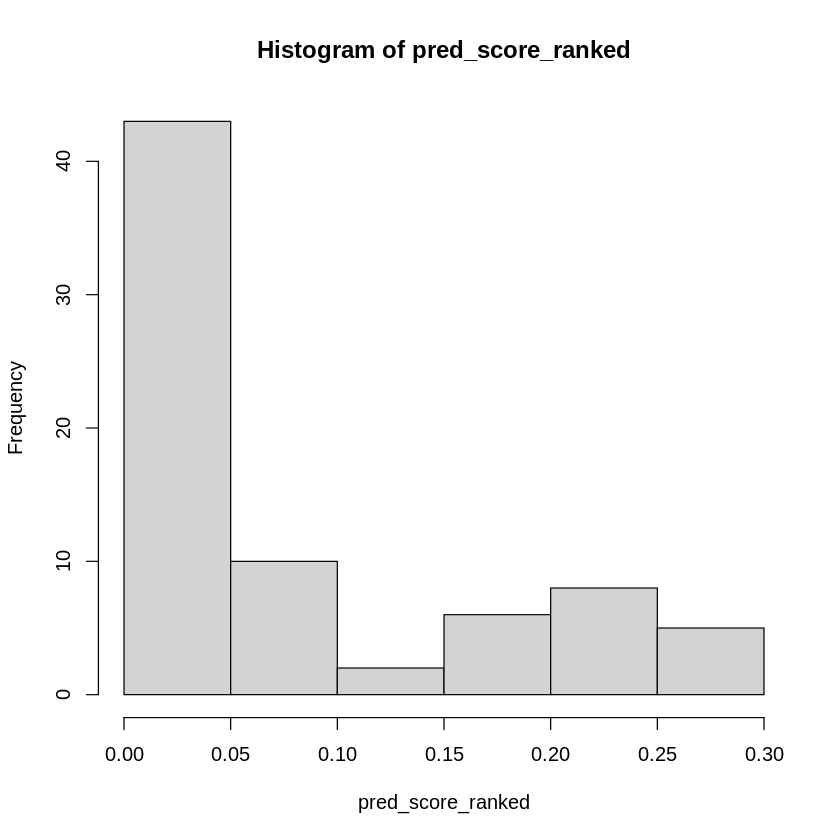

In [75]:
hist(pred_score_ranked)